In [41]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf
import keras
from keras import layers
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
df = pd.read_csv("../datasets/Task_2/3.csv")
df.drop(['ID'],axis=1,inplace=True)

<Axes: >

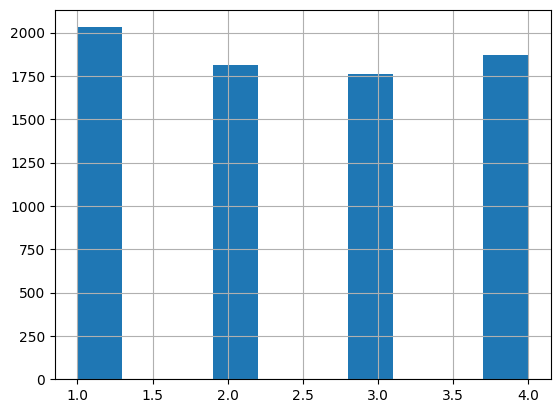

In [42]:
df['Segmentation'].hist()

In [43]:
corr_matrix = df.corr()['Segmentation']
corr_matrix.sort_values(ascending=False)
# => Profession does not really have any input so I removed the negtive correlation values. 
# Others that have almost no correlation can be removed later on

Segmentation                1.00
Ever_Married                0.40
Profession_Artist           0.38
Spending_Score              0.37
Age                         0.36
Graduated                   0.35
Var_1                       0.12
Profession_Executive        0.07
Gender                      0.04
Profession_Lawyer           0.02
Profession_Doctor          -0.04
Profession_nan             -0.04
Profession_Entertainment   -0.04
Family_Size                -0.05
Profession_Homemaker       -0.05
Profession_Engineer        -0.06
Work_Experience            -0.07
Profession_Marketing       -0.11
Profession_Healthcare      -0.34
Name: Segmentation, dtype: float64

In [44]:
removables = ['Profession_Healthcare', 'Profession_Marketing', 'Work_Experience', 'Profession_Engineer', 'Profession_Homemaker', 'Family_Size', 'Profession_Entertainment', 'Profession_nan','Profession_Doctor']
df = df.drop(removables, axis=1)

In [45]:
# let's assign actual names for the Segmentation Classes
# so we have nicer metrics and results later (after training model)
df['Segmentation'] = df['Segmentation'].replace({
    1: "1: A",
    2: "2: B",
    3: "3: C",
    4: "4: D"
})


In [46]:
df.head()

,Gender,Ever_Married,Age,Graduated,Spending_Score,Var_1,Segmentation,Profession_Artist,Profession_Executive,Profession_Lawyer
0,0,0.00,22,0.00,1,4,1: A,0,0,0
1,1,1.00,38,1.00,2,4,2: B,0,0,0
2,1,1.00,67,1.00,1,6,3: C,0,0,0
3,0,1.00,67,1.00,3,6,3: C,0,0,1
4,1,1.00,40,1.00,3,6,2: B,0,0,0


In [47]:
df.isna().sum()

Gender                  0
Ever_Married            0
Age                     0
Graduated               0
Spending_Score          0
Var_1                   0
Segmentation            0
Profession_Artist       0
Profession_Executive    0
Profession_Lawyer       0
dtype: int64

In [48]:
# everything else except the target variable
X = df.drop("Segmentation", axis=1)

# have only the target variable here (dependent variable)
y_temp = df['Segmentation']

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

# save the categories into a helper list for later purposes
categories = list(le.classes_)
categories

['1: A', '2: B', '3: C', '4: D']

In [49]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))
best_features = chi_2_features.fit(X_cat,y.astype(int))
pd.options.display.float_format = '{:.2f}'.format

# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)
# Gender, Profession and Var_1 have basically no effect

,Features,Score
2,Age,7204.87
6,Profession_Artist,763.56
1,Ever_Married,542.33
3,Graduated,370.29
4,Spending_Score,359.52
5,Var_1,42.23
7,Profession_Executive,38.66
8,Profession_Lawyer,26.46
0,Gender,8.04


In [50]:
# this time, let's split the data into 65% (training data) and 35% (temporary data)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.35)

# step 2, split the temporary data in HALF (0.5) => 17.5% test and 17.5% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [51]:
# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in classification depends on amount of output options in target variable
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/home/lukas/dev/venvs/DL/lib/python3.12/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368 (1.44 KB)

 Trainable params: 350 (1.37 KB)

 Non-trainable params: 18 (72.00 B)

In [52]:
model.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_val, y_val))

Epoch 1/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3300 - loss: 3.8706 - val_accuracy: 0.3991 - val_loss: 2.9961
Epoch 2/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4311 - loss: 2.3846 - val_accuracy: 0.4472 - val_loss: 1.8756
Epoch 3/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4298 - loss: 1.5739 - val_accuracy: 0.4572 - val_loss: 1.3535
Epoch 4/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4360 - loss: 1.3207 - val_accuracy: 0.4534 - val_loss: 1.2829
Epoch 5/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4387 - loss: 1.2882 - val_accuracy: 0.4778 - val_loss: 1.2576
Epoch 6/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4488 - loss: 1.2664 - val_accuracy: 0.4633 - val_loss: 1.2421
Epoch 7/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4496 - loss: 1.2635 - val_accuracy: 0.4817 - val_loss: 1.2370
Epoch 8/300
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4469 - loss: 1.2527 - val_accu

<Axes: >

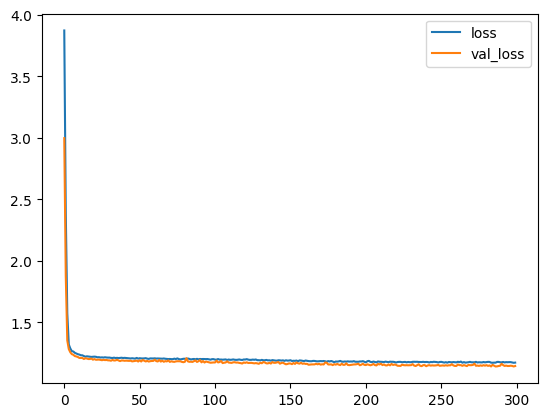

In [53]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()


<Axes: >

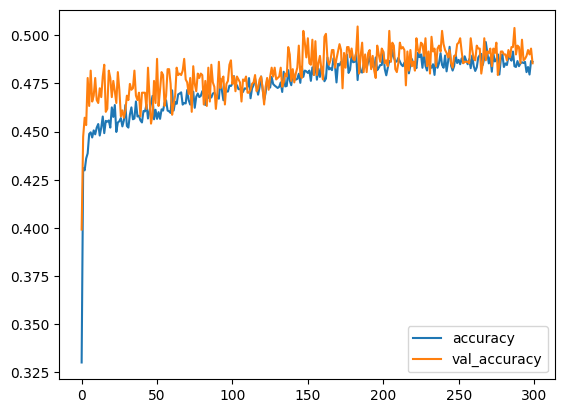

In [54]:
# For Accuracy and val_accuracy there is still a bit of room for improvement with values of ~65%  
loss_df[['accuracy', 'val_accuracy']].plot()

In [55]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly

# => the values almost match 
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[1.127849817276001, 0.504965603351593]

Train data evaluation:
[1.1620490550994873, 0.48806583881378174]


In [56]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Axes: >

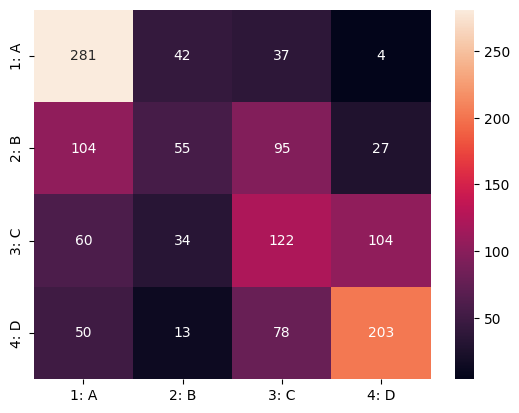

In [57]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g', 
            xticklabels=categories, yticklabels=categories)
# I have no idea what this is supposed to tell me

In [58]:
print(classification_report(y_test, test_predictions, target_names=categories))
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

# Model accuracy of ~64%

              precision    recall  f1-score   support

        1: A       0.57      0.77      0.65       364
        2: B       0.38      0.20      0.26       281
        3: C       0.37      0.38      0.37       320
        4: D       0.60      0.59      0.60       344

    accuracy                           0.50      1309
   macro avg       0.48      0.48      0.47      1309
weighted avg       0.49      0.50      0.49      1309


Model overall accuracy: 50.50%


In [59]:
# In multi category classification , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# get ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")
#=> .78 performs poor

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


0.7498478794739311

### Analysis:
Not a bad result for a first test but still a lot of room for improvements